In [1]:
# import required libraries
import cv2
import matplotlib.pyplot as plt
import dlib
import numpy as np
from utils.segmentation import *

In [2]:
# read image from file
name = "data\\2023_02_06_Altinget\\2023_02_06_Altinget\\0091_V.HEIC"
img = cv2.imread(name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


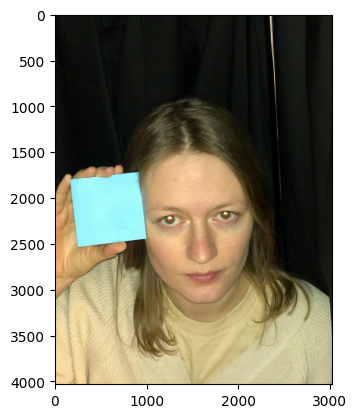

In [3]:
plt.imshow(img)

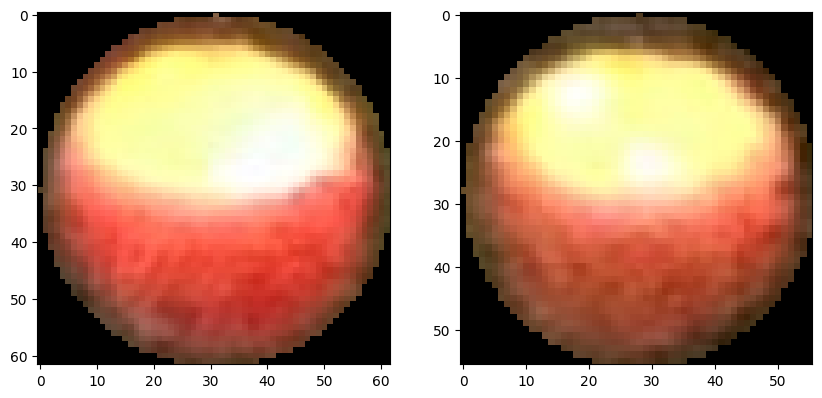

In [4]:
right_pupil, left_pupil = pipe(img)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(right_pupil)
ax[1].imshow(left_pupil)
plt.show()

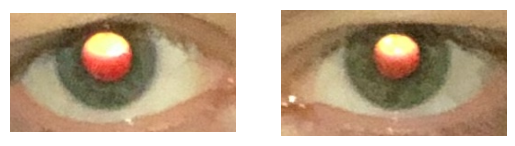

In [5]:
right_eye_img, left_eye_img = detect_eyes(img)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(right_eye_img)
ax[0].axis('off')
ax[1].imshow(left_eye_img)
ax[1].axis('off')
fig.show()

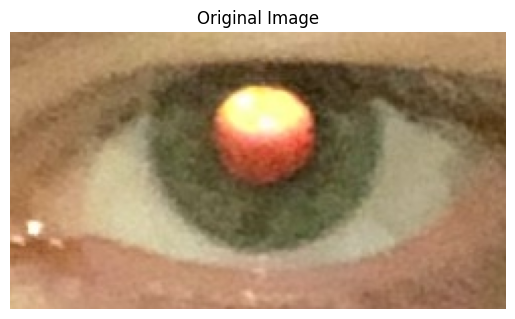

In [6]:
inp = left_eye_img.copy()
plt.imshow(inp)
plt.title("Original Image")
plt.axis("off")
plt.show()


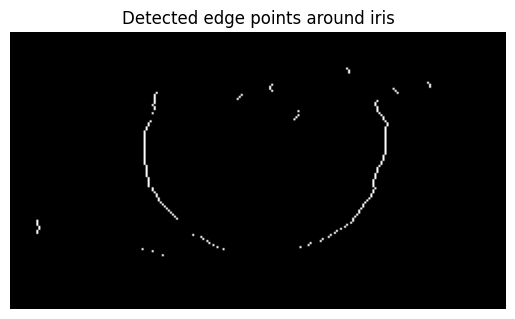

In [7]:
iris = get_cicle_points(inp, blur='median', threshold=40, use_bottom=False, use_top=False)
plt.imshow(iris, cmap='gray')
plt.title("Detected edge points around iris")
plt.axis("off")
plt.show()

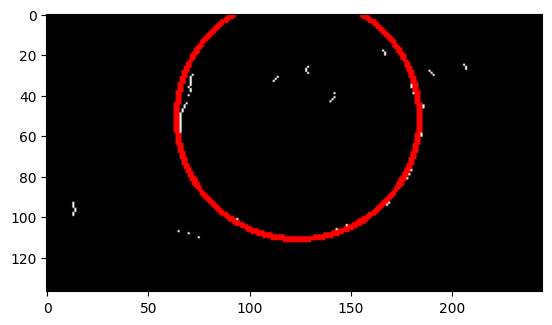

In [8]:
iris_center, iris_radius = get_circle(iris)
iris_circle = cv2.cvtColor(iris, cv2.COLOR_GRAY2RGB)
iris_circle = cv2.circle(iris_circle, iris_center, iris_radius, (255, 0, 0), 2)
plt.imshow(iris_circle)

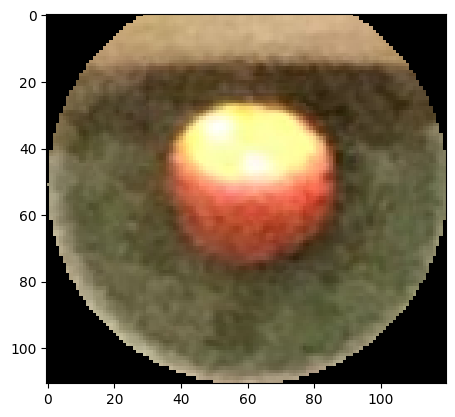

In [9]:
iris_cropped, iris_center_crop, iris_radius_crop = crop_circle(inp, iris_center, iris_radius)
plt.imshow(iris_cropped)

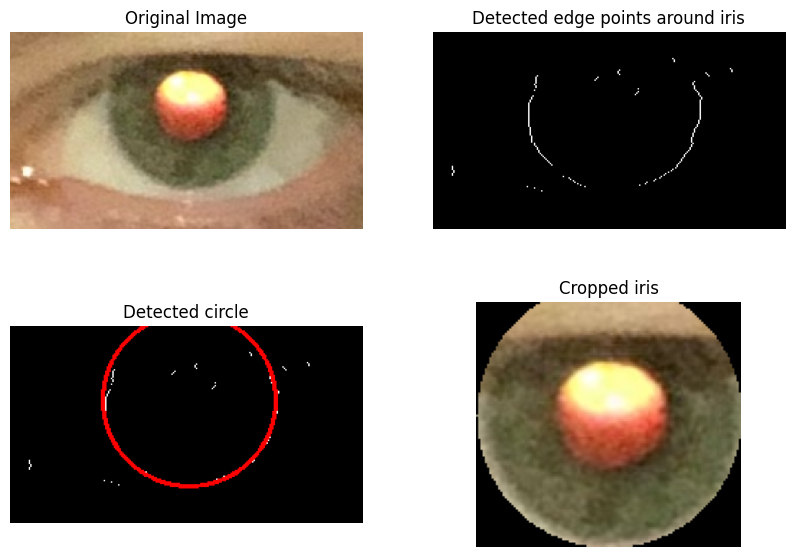

In [10]:
# create figure with 4 subplots
# plot original image, detected edge points, detected circle and cropped iris
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
ax[0, 0].imshow(inp)
ax[0, 0].set_title("Original Image")
ax[0, 0].axis("off")
ax[0, 1].imshow(iris, cmap='gray')
ax[0, 1].set_title("Detected edge points around iris")
ax[0, 1].axis("off")
ax[1, 0].imshow(iris_circle)
ax[1, 0].set_title("Detected circle")
ax[1, 0].axis("off")
ax[1, 1].imshow(iris_cropped)
ax[1, 1].set_title("Cropped iris")
ax[1, 1].axis("off")

plt.show()


In [11]:
def get_pupil_channels(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    r, g, bl = cv2.split(img)
    y, cr, cb = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb))
    channels = [l, a, b, h, s, v, r, g, bl, y, cr, cb]
    channels = [cv2.GaussianBlur(channel, (5, 5), 0) for channel in channels]
    channels = [cv2.equalizeHist(channel) for channel in channels]
    return channels

In [12]:
def feature_score(feature, iris_center, iris_radius):
    pupil_r = iris_radius // 2 - 10
    feature_mask = np.zeros_like(feature, dtype=np.uint8)
    cv2.circle(feature_mask, iris_center, iris_radius, 255, thickness=-1)
    # set pixels outside the circle to 0
    feature = cv2.bitwise_and(feature, feature_mask)
    mask = np.zeros_like(feature, dtype=np.uint8)
    cv2.circle(mask, iris_center, pupil_r, 255, thickness=-1)
    center_mask = np.zeros_like(feature, dtype=np.uint8)
    cv2.circle(center_mask, iris_center, 5, 255, thickness=-1)
    center_mask = cv2.bitwise_not(center_mask)
    mask = cv2.bitwise_and(mask, center_mask)

    inverted_mask = cv2.bitwise_not(mask)
    inverted_mask = cv2.bitwise_and(inverted_mask, feature_mask)
    inverted_mask = cv2.bitwise_and(inverted_mask, center_mask)

    mean_intensity_pupil = cv2.mean(feature, mask=mask)[0]
    mean_intensity_iris = cv2.mean(feature, mask=inverted_mask)[0]
    score = round((mean_intensity_pupil - mean_intensity_iris) ** 2)
    if mean_intensity_pupil < mean_intensity_iris:
        # invert feature
        feature = cv2.bitwise_not(feature)
        feature = cv2.bitwise_and(feature, feature_mask)
    return feature, score

In [13]:
channels = get_pupil_channels(iris_cropped)
scores = []
fixed_channels = []
for channel in channels:
    channel, score = feature_score(channel, iris_center_crop, iris_radius_crop)
    scores.append(score)
    fixed_channels.append(channel)
scores[6] = scores[6] * 2
scores[3] = scores[3] * 1.5
best_channel = np.argmax(scores)
input_channel = fixed_channels[best_channel]

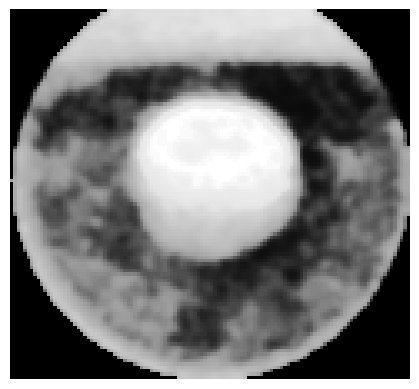

In [14]:
plt.imshow(input_channel, cmap='gray')
plt.axis('off')
plt.show()

In [15]:
np.argmax(scores)

6

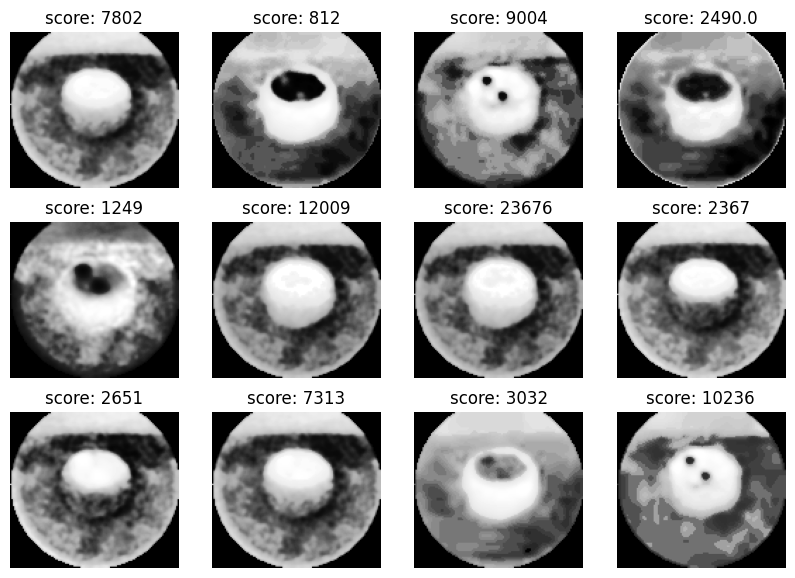

In [16]:
# plot all channels
fig, ax = plt.subplots(3, 4, figsize=(10, 7))
for i in range(3):
    for j in range(4):
        ax[i, j].imshow(fixed_channels[i * 4 + j], cmap='gray')
        ax[i, j].axis('off')
        ax[i, j].set_title(f'score: {scores[i * 4 + j]}')
plt.show()

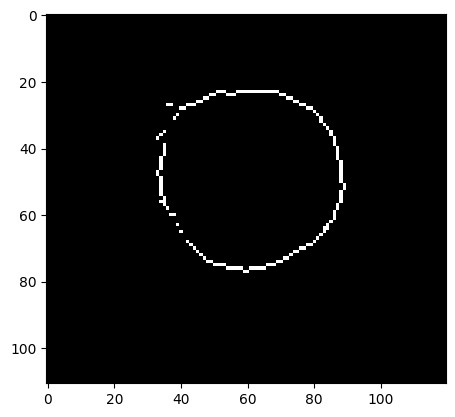

In [17]:
pupil = get_cicle_points(input_channel, channel='single', kernel='sobel',blur='median',threshold=100, mask_center=iris_center_crop, mask_radius=iris_radius_crop-25, edge_detection='inverse', use_top=True)
plt.imshow(pupil, cmap='gray')

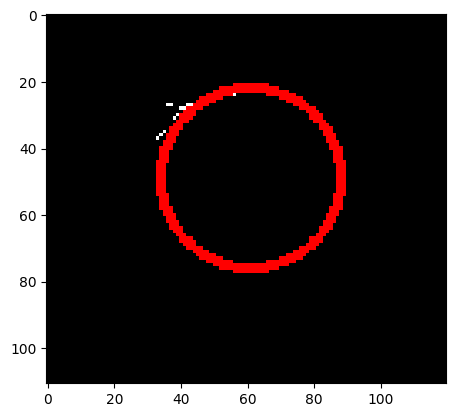

In [18]:
pupil_center, pupil_radius = get_circle(pupil)
pupil_circle = cv2.cvtColor(pupil, cv2.COLOR_GRAY2RGB)
pupil_circle = cv2.circle(pupil_circle, pupil_center, pupil_radius, (255, 0, 0), 2)
plt.imshow(pupil_circle)

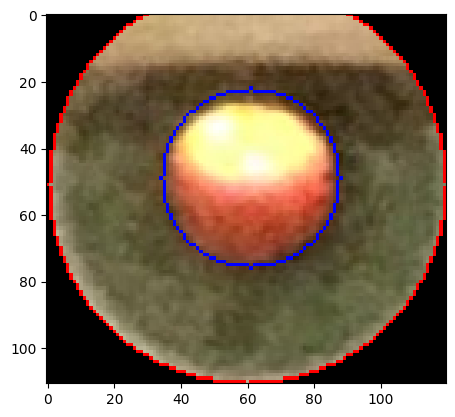

In [19]:
# draw circle on original image
img_circle = iris_cropped.copy()
img_circle = cv2.circle(img_circle, iris_center_crop, iris_radius_crop, (255, 0, 0), 1)
img_circle = cv2.circle(img_circle, pupil_center, pupil_radius, (0, 0, 255), 1)
plt.imshow(img_circle)

In [20]:
# otsu thresholding
gray = cv2.cvtColor(iris_cropped, cv2.COLOR_RGB2GRAY)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# set pixels inside the pupil to black
mask = np.zeros_like(thresh)
mask = cv2.circle(mask, pupil_center, pupil_radius+1, (255, 255, 255), -1)
mask = cv2.bitwise_not(mask)
thresh = cv2.bitwise_and(thresh, mask)
thresh = cv2.bitwise_not(thresh)

# mask iris with threshold
iris_crop_tmp = cv2.bitwise_and(iris_cropped, iris_cropped, mask=thresh)

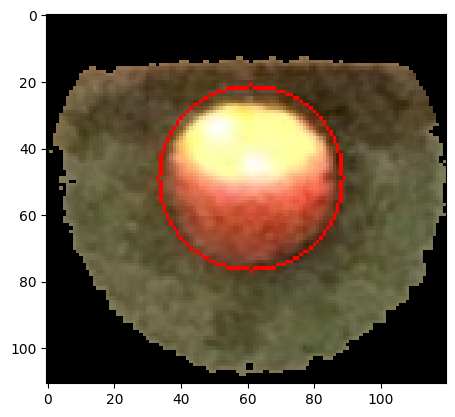

In [21]:
# draw pupil circle on cropped iris
iris_crop_circle = iris_crop_tmp.copy()
iris_crop_circle = cv2.circle(iris_crop_circle, pupil_center, pupil_radius+1, (255, 0, 0), 1)
plt.imshow(iris_crop_circle)

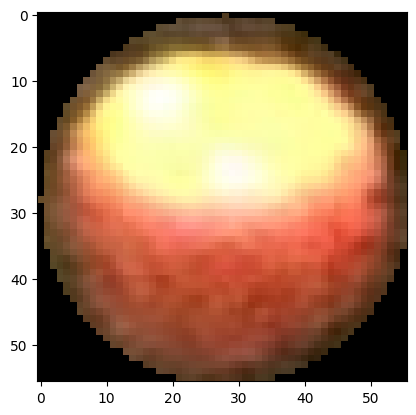

In [22]:
# crop pupil
pupil_crop, center, radius = crop_circle(iris_cropped, pupil_center, pupil_radius+1)
plt.imshow(pupil_crop)

In [23]:
cv2.imwrite('test_pupil.png', cv2.cvtColor(pupil_crop, cv2.COLOR_RGB2BGR))

True

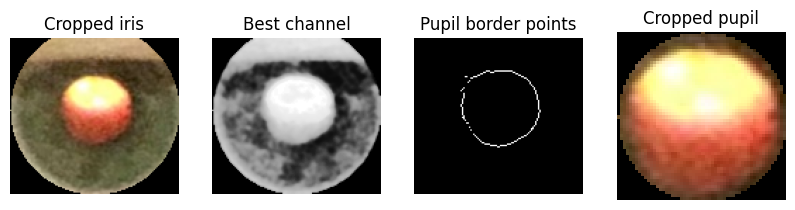

In [24]:
# create figure with 4 subplots
# plot cropped iris, best channel, detected pupil and cropped pupil
fig, ax = plt.subplots(1, 4, figsize=(10, 7))
ax[0].imshow(iris_cropped)
ax[0].set_title("Cropped iris")
ax[0].axis("off")
ax[1].imshow(input_channel, cmap='gray')
ax[1].set_title("Best channel")
ax[1].axis("off")
ax[2].imshow(pupil, cmap='gray')
ax[2].set_title("Pupil border points")
ax[2].axis("off")
ax[3].imshow(pupil_crop)
ax[3].set_title("Cropped pupil")
ax[3].axis("off")

plt.show()